In [ ]:
# Needs OpenCV (Computer Vision) for image processing
# Needs ipympl for making matplotlib talk nicely with the widgets

If the following doesn't say the active environment is `DropPinchoff` something may have gone wrong with the setup.  You can still use this notebook, but you'll have to install opencv and ipympl manually.

In [1]:
!conda info


     active environment : DropPinchoff
    active env location : /opt/anaconda3/envs/DropPinchoff
            shell level : 2
       user config file : /Users/kevin 1/.condarc
 populated config files : /Users/kevin 1/.condarc
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __osx=10.16=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /opt/anaconda3  (writable)
      conda av data dir : /opt/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/osx-64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/osx-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/osx-64
                          https://repo.anaconda.com/pkgs/r/no

In [ ]:
pip install py-opencv

In [ ]:
pip install ipympl

In [2]:
# Import the libraries
%matplotlib widget

import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
max_length = 200  
    # Defines the number of frames to read over

In [4]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

fname = "Drop.mp4"

cap = cv2.VideoCapture(fname)
    # Name of video file.
    
img_list = []
for i in range(0,max_length):
    ret, img = cap.read()
    if (not ret):
        print("End of file reached!")
        raise StopExecution # gracefully shuts down when end of file is reached
    img_list.append(img)

End of file reached!


In [5]:
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual,Layout
import ipywidgets as widgets
plt.ioff() #prevents us from drawing extra plots while setting up

#These can all be changed fairly safely
target_size = 10 #size of zoom area.  Most useful thing to change if you need to see more.
tval = 180
bval = 10
xval = 100
brightness = 1.0
frame = 0

#Do not mess with
xdim = len(img_list[0][0])-1
ydim = len(img_list[0])-1


#This establishes all the widgets used for controls and display
y_slider = widgets.FloatRangeSlider(min=0,max=ydim,step=1,orientation='vertical',description='width',layout=Layout(height='300px'))
x_slider = widgets.IntSlider(min=0,max=xdim,description='length',layout=Layout(width='100%'))
bri_slider = widgets.FloatSlider(min=1,max=10,orientation='vertical',description='brightness')
frame_slider = widgets.IntSlider(min=0,max=ydim,orientation='vertical',description='frame')
record_button = widgets.Button(description='save')
record_next_button = widgets.Button(description='save & advance')
drop_disp = widgets.Output(layout=Layout(width='40%'))
neck_disp = widgets.Output(layout=Layout(width='50%'))


# Now we set up our image of the drop
fig = plt.figure(figsize=(7,3),constrained_layout=True)
gs = fig.add_gridspec(2,8) # gs stands for 'grid spec', and gives better control over the relative size of subplots

ax = fig.add_subplot(gs[0:2,0:-2])
drop_img = ax.imshow(np.clip(brightness*img_list[0]/100., 0, 1),origin='lower') #show the image
ax.set_yticks(np.linspace(0,len(img_list[0]),5))
drop_meas = ax.vlines(xval,tval,bval,color='red') #show a measurement line
minx,maxx = plt.gca().get_xlim() #Fix for zooming in
miny,maxy = plt.gca().get_ylim()
    
#This sets up zoomed-in areas for better visualization
ax_top = fig.add_subplot(gs[0, -2:])
ax_top.yaxis.tick_right()
drop_img_t = ax_top.imshow(np.clip(brightness*img_list[0]/100., 0, 1),origin='lower')
drop_meas_t = ax_top.vlines(xval,tval,bval,color='red',linewidth=3)

ax_bot = fig.add_subplot(gs[1, -2:])
ax_bot.yaxis.tick_right()
drop_img_b = ax_bot.imshow(np.clip(brightness*img_list[0]/100., 0, 1),origin='lower')
drop_meas_b = ax_bot.vlines(xval,tval,bval,color='red',linewidth=3)

#Extra code to center our zoomed plots on the ends of our measuring line
def set_xlims(ax_target,x,ts=target_size,xdim=xdim):
    if x < ts:
        ax_target.set_xlim(0, 2*ts)
    elif x > xdim-ts:
        ax_target.set_xlim(xdim-(2*ts),xdim)
    else:
        ax_target.set_xlim(x-ts,x+ts)

def set_ylims(ax_target,y,ts=target_size,ydim=ydim):
    if y < ts:
        ax_target.set_ylim(0, 2*ts)
    elif y > ydim-ts:
        ax_target.set_ylim(ydim-(2*ts),ydim)
    else:
        ax_target.set_ylim(y-ts,y+ts)

set_xlims(ax_top,xval)
set_xlims(ax_bot,xval)
set_ylims(ax_top,tval)
set_ylims(ax_bot,bval)


# This part will create a plot of our neck radius versus frame as we go
fig2,ax2 = plt.subplots(figsize = (4,2),dpi=100)
fig2.canvas.toolbar_visible = False
fig2.canvas.header_visible = False
ax2.set_title("Radius vs frame")
neck_img, = ax2.plot([0],[0],'k.-')
ax2.autoscale_view()

# Zero out any existing measurements when resetting
measurements = [[]]

# Make sure our sliders match up with our initial settings
y_slider.value = [bval,tval] #Not a bug, the slider just works this way.
x_slider.value = xval
bri_slider.value = brightness
frame_slider.value = frame


# The following functions all tie into sliders/buttons and pass their values onto the plot to update it
def y_change(change): 
    global tval,bval
    tval = change['new'][1] #this makes the directions behave as you'd expect
    bval = change['new'][0]
    newshowframe(tval,bval,xval,brightness,frame)
    
def x_change(change): 
    global xval
    xval = change['new']
    newshowframe(tval,bval,xval,brightness,frame)
        
def brightness_change(change): 
    global brightness
    brightness = change['new']
    newshowframe(tval,bval,xval,brightness,frame)
    
def frame_change(change): 
    global frame
    frame = change['new']
    newshowframe(tval,bval,xval,brightness,frame)
    
def record(value): 
    global measurements
    global frame,tval,bval,xval
    try:  # This will be what normally happens: we just add our data onto the end of a list
        measurements = np.append(measurements,[[frame,abs(tval-bval),bval,tval,xval]],axis=0)
    except: # This happens at the first time we record something, since there's no list to add to.
        measurements = np.array([[frame,abs(tval-bval),bval,tval,xval]])

# As expected, this records the current neck radius & frame and then advances to the next frame.
def record_next(value):
    record(value)
    global measurements
    global frame
    frame +=1
    frame_slider.value +=1
    newshowframe(tval,bval,xval,brightness,frame)
    sort_index = np.argsort(measurements[:,0])
    neck_img.set_data(measurements[:,0][sort_index],measurements[:,1][sort_index])
    ax2.relim()
    ax2.autoscale_view()
    fig2.canvas.draw_idle()
    
#These all tie sliders and buttons to their update functions
y_slider.observe(y_change, names='value')
x_slider.observe(x_change, names='value')
bri_slider.observe(brightness_change, names='value')
frame_slider.observe(frame_change, names='value')
record_button.on_click(record)
record_next_button.on_click(record_next)

#This is the part that redraws our drop any time we change something relevant.
def newshowframe(top=tval,bot=bval,xpos=xval,bright =brightness,frm=frame):
    global drop_img
    global drop_meas,drop_meas_t,drop_meas_b
    minx,maxx = ax.get_xlim()
    miny,maxy = ax.get_ylim()
    drop_img.set_data(np.clip(bright*img_list[frm]/100., 0, 1))
    drop_img_t.set_data(np.clip(bright*img_list[frm]/100., 0, 1))
    drop_img_b.set_data(np.clip(bright*img_list[frm]/100., 0, 1))  
    drop_meas.get_paths()[0].vertices = [[xpos,top],[xpos,bot]]
    drop_meas_t.get_paths()[0].vertices = [[xpos,top],[xpos,bot]]
    drop_meas_b.get_paths()[0].vertices = [[xpos,top],[xpos,bot]]
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    set_xlims(ax_top,xpos)
    set_xlims(ax_bot,xpos)
    set_ylims(ax_top,tval)
    set_ylims(ax_bot,bval)
    fig.canvas.draw_idle()

# These set up a nice layout of the controls    
neck_selector = widgets.HBox([y_slider,widgets.VBox([fig.canvas,x_slider],layout=Layout(height='350px',width='50pc'))])
other_controls = widgets.HBox([bri_slider,frame_slider,widgets.VBox([record_next_button,record_button]),fig2.canvas])
controls = widgets.VBox([neck_selector,other_controls])
display(controls)
# now we let things update again!

plt.ion();


----

In [6]:
# This cell will re-plot your data and save it to your computer
import time

try:  #If any of the following code fails, it will instead run the except branch below
    sorted_index = np.argsort(measurements[:,0])
    sorted_frames = measurements[:,0][sorted_index]
    sorted_sizes = measurements[:,1][sorted_index]
    # the previous bit re-orders your data in case you went backwards at some point.  Not strictly needed.
    fig,ax = plt.subplots()
    ax.plot(sorted_frames,sorted_sizes,'k.-')
    
    dat_name = fname[:-1*fname.find(".")] + "_" + str(int(time.time())) + ".tsv"# this cuts off the current suffix and adds the time
    toptxt = "Frame \t Radius \t Bottom \t Top \t Position"
    np.savetxt(dat_name,measurements[:][sorted_index],header=toptxt) # This sorts your data before saving too!
except:
    print("No datapoints selected yet.  Use the controls to save neck radii first.")
    

No datapoints selected yet.  Use the controls to save neck radii first.


# Automating the process

Now, we can also use Python to do some of our dirty work here.  To start, we'll need to `threshold` the image: any pixels darker than the threshold are turned black, and any brighter are turned white.  In this case, we invert this, but the idea stands.  This eliminates "fuzzy" edges, but it also loses some nuance in decision making.

The code snippet below will let you see what changing the thresholding value does to the drop image.  The value you set with the slider will be used throughout the data

interactive(children=(IntSlider(value=40, description='t_val', max=255), IntSlider(value=0, description='frm',…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
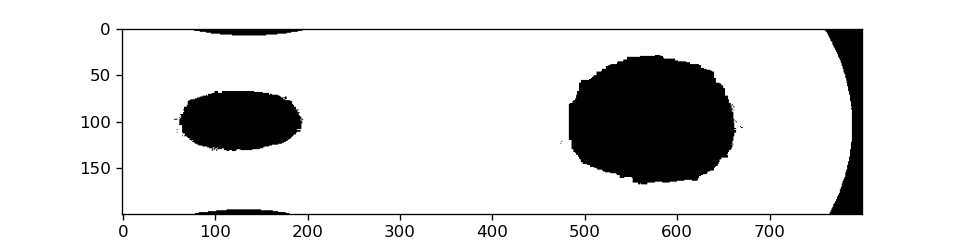

In [7]:
from ipywidgets import interact,fixed
grey_threshold = 40

fig,ax = plt.subplots(figsize = (8,2),dpi=120)
thresh_img = ax.imshow(img_list[0])

def try_threshold(t_val=40,frm=0):
    global grey_threshold
    grey_threshold = t_val
    ret,thresh = cv2.threshold(img_list[frm],t_val,255,cv2.THRESH_BINARY_INV)
    thresh_img.set_data(thresh)
  
interact(try_threshold, t_val=(0,255),frm=(0,len(img_list)-1));

The other point of concern is that we don't want to read data from the bottom of the drop by mistake.  To avoid this, we're goint to define a maximum `x` value that the algorithm looks at that doesn't include the leading edge of the drop.

The following cell will let figure out where to cut off the neck searching algorithm by selecting a point that the neck never passes.  The region excluded will be shaded in red.

interactive(children=(IntSlider(value=40, description='t_val', max=255), IntSlider(value=0, description='frm',…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
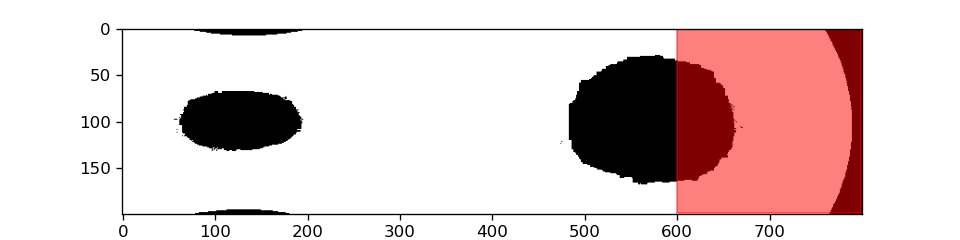

In [8]:
from ipywidgets import interact,fixed
import matplotlib.patches as patches
x_max = 600

fig,ax = plt.subplots(figsize = (8,2),dpi=120)
thresh_img = ax.imshow(img_list[0])
exclude = ax.add_patch(patches.Rectangle(xy=(x_max , 0),width=xdim-x_max , height=ydim,color='red', fill=True,alpha=0.5))

def try_threshold(t_val=40,frm=0,xmax = x_max):
    global grey_threshold
    global x_max
    grey_threshold = t_val
    x_max = xmax
    try:
        ret,thresh = cv2.threshold(img_list[frm],t_val,255,cv2.THRESH_BINARY_INV)
        thresh_img.set_data(thresh)
        exclude.set_x(xmax)
        exclude.set_width(xdim-xmax)
    except:
        print("End of data reached!")

interact(try_threshold, t_val=(0,255),frm=(0,ydim),xmax=(0,xdim));

With that, you can find the outline of the drop with the `findContours` function.  This creates a list of points along the border of white areas.  

We select the largest contour by going through each list of points and finding the longest one using `contours[largest_contour]`.

(0.0, 799.0, 0.0, 199.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
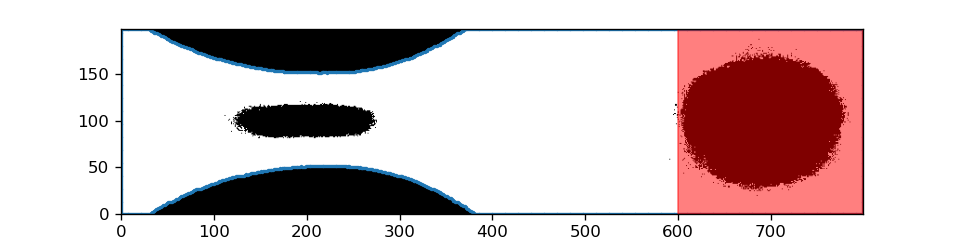

In [9]:
ret,thresh = cv2.threshold(img_list[72],grey_threshold,255,cv2.THRESH_BINARY_INV)
# The next line does a lot, but at its cour it is using the find Contours function to outline contiguous white areas
contours, hierarchy = cv2.findContours(cv2.cvtColor(thresh,cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
largest_contour=0
for index,item in enumerate(contours):
    if len(item) > len(contours[largest_contour]):
        largest_contour=index
[x,y]=np.transpose(contours[largest_contour]) # This unpacks the points in the largest contour

fig,ax = plt.subplots(figsize = (8,2),dpi=120)
ax.imshow(thresh,origin='upper');
ax.scatter(x,y,s=1);
ax.add_patch(patches.Rectangle(xy=(x_max , 0),width=xdim-x_max , height=ydim,color='red', fill=True,alpha=0.5))
plt.axis([0, xdim , 0, ydim])

Now, we could manually peruse the list of points in the contour and look for the closest one.  But that would be horribly tedious by hand since there can be thousands of them!

Instead, we'll create a loop finds points in the contour belonging to each 1 pixel vertical slice of the image.  We then find the difference in distance between the top-most and bottom-most ones (this avoids errors due to highlights that can crop ut) and save it.  If it's the smallest one we've found, we update our `thismin` variable.

We'll also add a line showing where the smallest part of the neck is detected.  Note that it maight jump about a bit in the exact `x` position, but the width usually will vary smoothly.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
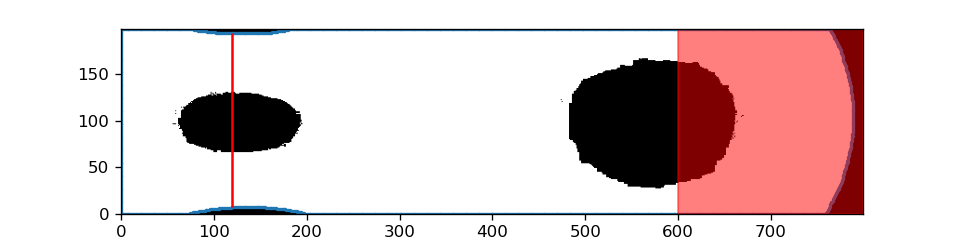

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
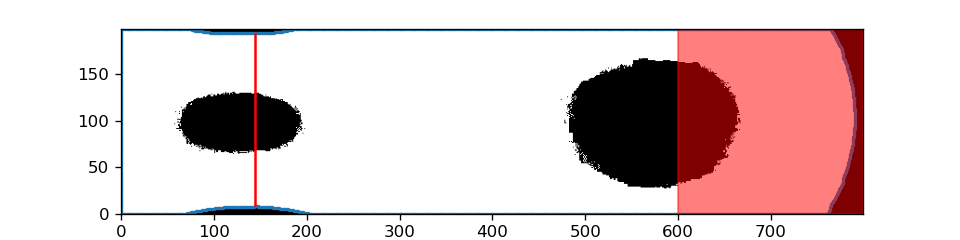

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
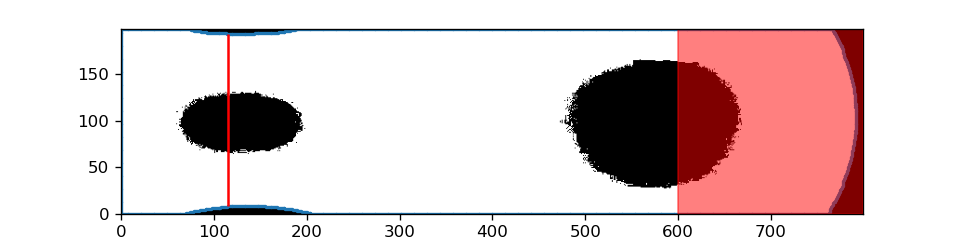

In [10]:
import matplotlib.patches as patches

frames = [] 
neck = []  #Width of neck in pixels
neckposition = []

for i in range(0,3):
    ret,thresh = cv2.threshold(img_list[i],grey_threshold,255,cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(cv2.cvtColor(thresh,cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    largest_contour=0
    for index,item in enumerate(contours):
        if len(item) > len(contours[largest_contour]):
            largest_contour=index
    [x,y]=np.transpose(contours[largest_contour])

    
    dist= []
    radius = ydim;  # Maximum radius is the height of the image
    thismin = ydim;
    thisminposition = 0;  # Position of the minimum for the current frame.
    minpts = [0,ydim]
    for i in range(1,x_max):
        radius = ydim
        matched = np.where(x == i, True,False)
        if(matched.any()):
            radius = max(y[matched])-min(y[matched])
        if(radius< thismin):
            thismin = radius
            thisminposition = i   
            minpts = [min(y[matched]),max(y[matched])]
        dist.append([i,radius])
    neck.append(thismin)
    neckposition.append(thisminposition)  
    
    fig,ax =  plt.subplots(figsize = (8,2),dpi=120)
    ax.imshow(thresh,origin='upper');
    ax.scatter(x,y,s=1);
    plt.axis([0, xdim , 0, ydim])
    ax.vlines(thisminposition,minpts[0],minpts[1],color='red')
    ax.add_patch(patches.Rectangle(xy=(x_max , 0),width=xdim-x_max , height=ydim,color='red', fill=True,alpha=0.5))
    fig.title = thismin

    

Finally, this next part will go through all the frames, find the position of the minima, and save the value as `neckposition`.

You can also uncomment the top lines here to set values for the max horizontal position and threshold so you don't need to reset it every time.

In [11]:
#x_max = 600
#grey_threshold = 40

measurements = []
frames = [] 
neck = []  #Width of neck in pixels
neckposition = []
progress = widgets.IntProgress(value=0, min=0,max=len(img_list),description="Progress")
display(progress)
for index,item in enumerate(img_list):
    ret,thresh = cv2.threshold(item,grey_threshold,255,cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(cv2.cvtColor(thresh,cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    largest_contour=0
    for index,item in enumerate(contours):
        if len(item) > len(contours[largest_contour]):
            largest_contour=index
    [x,y]=np.transpose(contours[largest_contour])

    dist= []
    radius = ydim;  # Maximum radius is the height of the image
    thismin = ydim;
    minpts = [0,ydim]
    thisminposition = 0;  # Position of the minimum for the current frame.
    for i in range(1,x_max):
        radius = ydim
        matched = np.where(x == i, True,False)
        if(matched.any()):
            radius = max(y[matched])-min(y[matched])
        if(radius< thismin):
            thismin = radius
            minpts = [min(y[matched]),max(y[matched])]
            thisminposition = i   
        dist.append([i,radius])
    neck.append(thismin)
    neckposition.append(thisminposition) #there's a bit of duplication going on in this code, but it works.
    
    global measurements
    try:  # This will be what normally happens: we just add our data onto the end of a list
        measurements = np.append(measurements,[[i,thismin,minpts[0],minpts[1],thismin]],axis=0)
    except: # This happens at the first time we record something, since there's no list to add to.
        measurements = np.array([[i,thismin,minpts[0],minpts[1],thismin]])
    
    fig,ax = plt.subplots(figsize = (10,4),dpi=120)
    ax.imshow(thresh,origin='upper', animated=True);
    ax.scatter(x,y,s=1);
    plt.axis([0, xdim , 0, ydim])
    ax.vlines(thisminposition,minpts[0],minpts[1],color='red')
    ax.add_patch(patches.Rectangle(xy=(x_max , 0),width=xdim-x_max , height=ydim,color='red', fill=True,alpha=0.5))
    fig.title = thismin
    frames.append(fig)
    progress.value +=1
plt.close('all') #keeps the code from opening up far too many figures
print("Finished!")

IntProgress(value=0, description='Progress', max=126)

/var/folders/rl/tl4qtvj57b566bjy5j9py4xh0000gp/T/ipykernel_57362/4221957035.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(figsize = (10,4),dpi=120)


Finished!


The next bit makes it so you can browse through the data and make sure nothing crazy is going on.  There will be a red annotation on the image where the smallest neck is detected.

In [12]:
from IPython.display import clear_output
fig, ax = plt.subplots();
disp = widgets.Output();

def showframe(frm=0):
    global frames
    disp.clear_output(wait=True);
    with disp:
        display(frames[frm]);

frame_slider2 = widgets.IntSlider(min=0,max=len(frames)-1,value=0,continuous_update=False) #I got lazy with names, so sue me.
def frame_change2(change): 
    showframe(change['new']);
    
frame_slider2.observe(frame_change2, names='value');
showframe(0);
display(disp);
display(frame_slider2);
plt.close('all')

Output()

IntSlider(value=0, continuous_update=False, max=125)

Finally, this plots our data and outputs the positions to a handy .tsv file.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
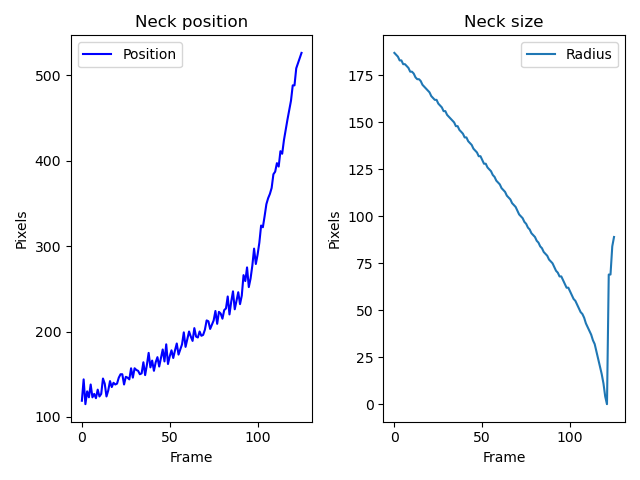

In [13]:
import time
fig, (ax,ay) = plt.subplots(1,2)
scaletype = "linear"

ax.set_yscale(scaletype)
ax.set_xscale(scaletype)

ax.plot(neckposition,label = "Position",color="b")
ay.plot(neck,label = "Radius")

ax.set_title("Neck position")
ay.set_title("Neck size")


ax.set_ylabel("Pixels")
ax.set_xlabel("Frame")

ay.set_ylabel("Pixels")
ay.set_xlabel("Frame")


plt.tight_layout()
ax.legend()
ay.legend()

 
dat_name = fname[:-1*fname.find(".")] + "_auto_" + str(int(time.time())) + ".tsv"# this cuts off the current suffix and adds the time
toptxt = "Frame \t Radius \t Bottom \t Top \t Position"
sorted_index = np.argsort(measurements[:,0])
np.savetxt(dat_name,measurements[:][sorted_index],header=toptxt) # This sorts your data before saving too!

----